# Preferential Sampling Adjustment

In [1]:
import numpy as np
import rasterio as rio
from matplotlib import pyplot as plt
from sklearn.feature_extraction import image
from libpysal.weights import lat2W

import pymc as pm
import arviz as az

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [2]:
with rio.open('../data/preprocessed/temperature/durham_stations_w_temp_500m.tif') as src:
    temp = src.read(1)

with rio.open('../data/preprocessed/temperature/durham_station_count_w_temp_500m.tif') as src:
    counts = src.read(1)


In [6]:
# Create adjacency matrix for the gridded data
adj = lat2W(temp.shape[0], temp.shape[1]).to_sparse()

# Ensure that the temperature data is a masked array so that it is treated correctly.
temp = np.ma.masked_values(temp, value=0)
N = temp.shape[0] * temp.shape[1]

temp_flat = temp.flatten()

In [38]:
with pm.Model() as model:

    # Priors
    sigma = pm.Exponential('sigma', 1)
    eps = pm.Exponential('eps', 1)
    # mu = pm.Normal('mu', mu=np.nanmean(temp), sigma=0.5)
    phi = pm.ICAR('phi', W=adj.todense())

    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1)

    # Likelihood
    T = pm.Normal('temp', mu + phi*sigma, sigma=eps, observed=temp_flat)

    intensity = pm.math.exp(alpha + beta*T)
    lam = pm.Poisson('lam', mu = intensity, observed=counts.flatten())

    # Sample
    trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.95)

/Users/zdc6/mambaforge/envs/pspws/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in temp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, eps, phi, alpha, beta, temp_unobserved]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 746 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


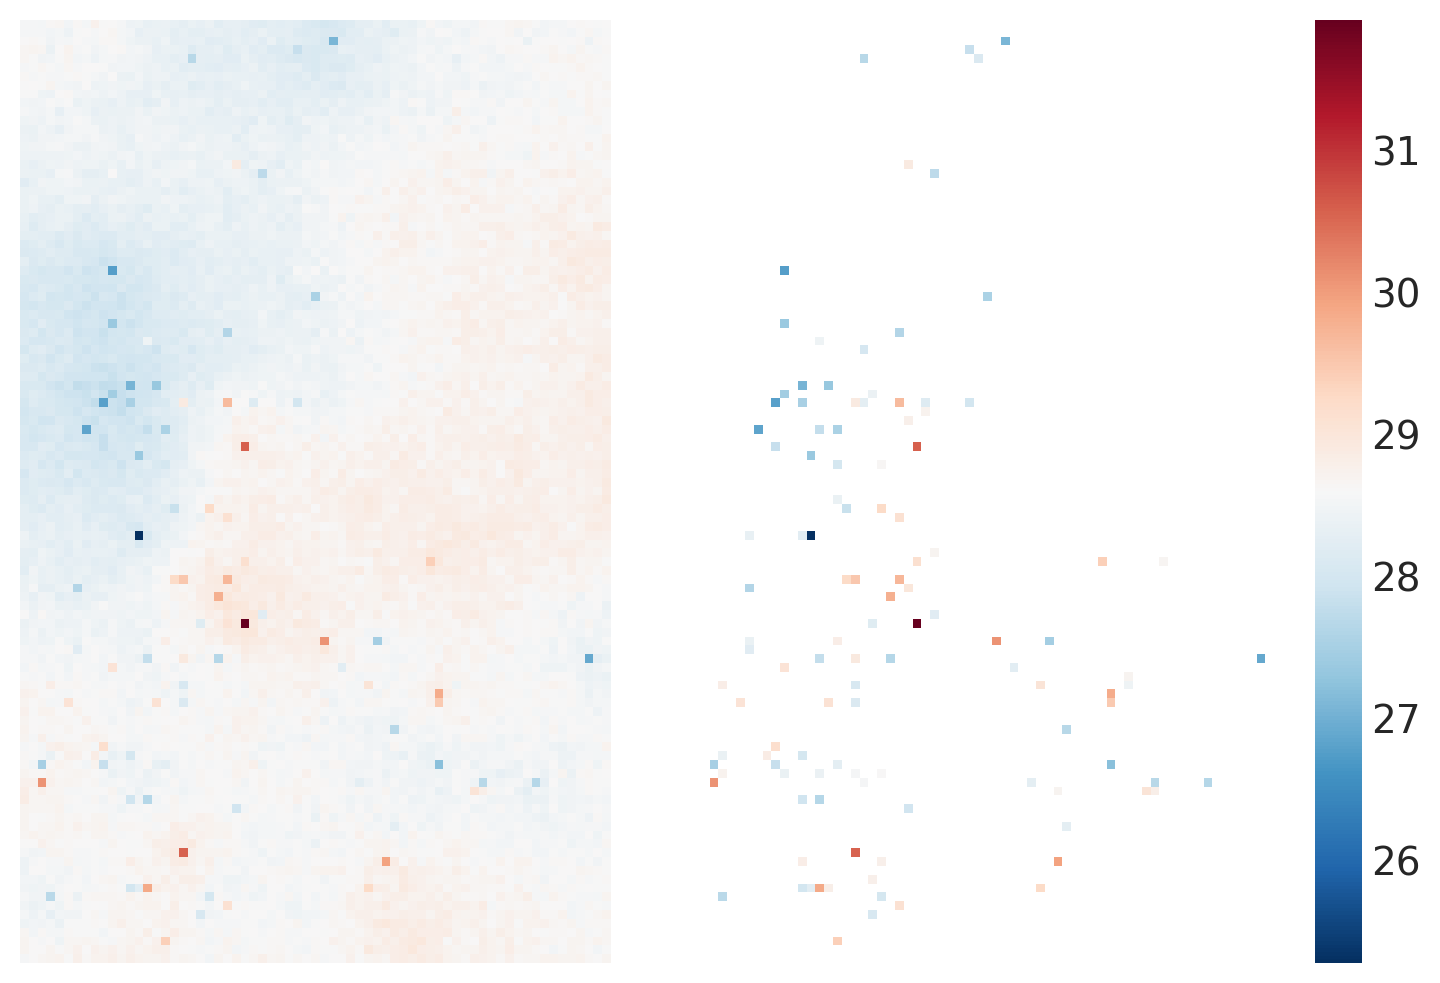

In [37]:
mean_temp = trace.posterior['temp'].mean(axis=(0,1)).values

plt.subplot(1,2,1)
plt.imshow(mean_temp.reshape(temp.shape), cmap='RdBu_r')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(temp, cmap='RdBu_r')
plt.axis('off')
plt.colorbar()

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'eps'}>, <Axes: title={'center': 'eps'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

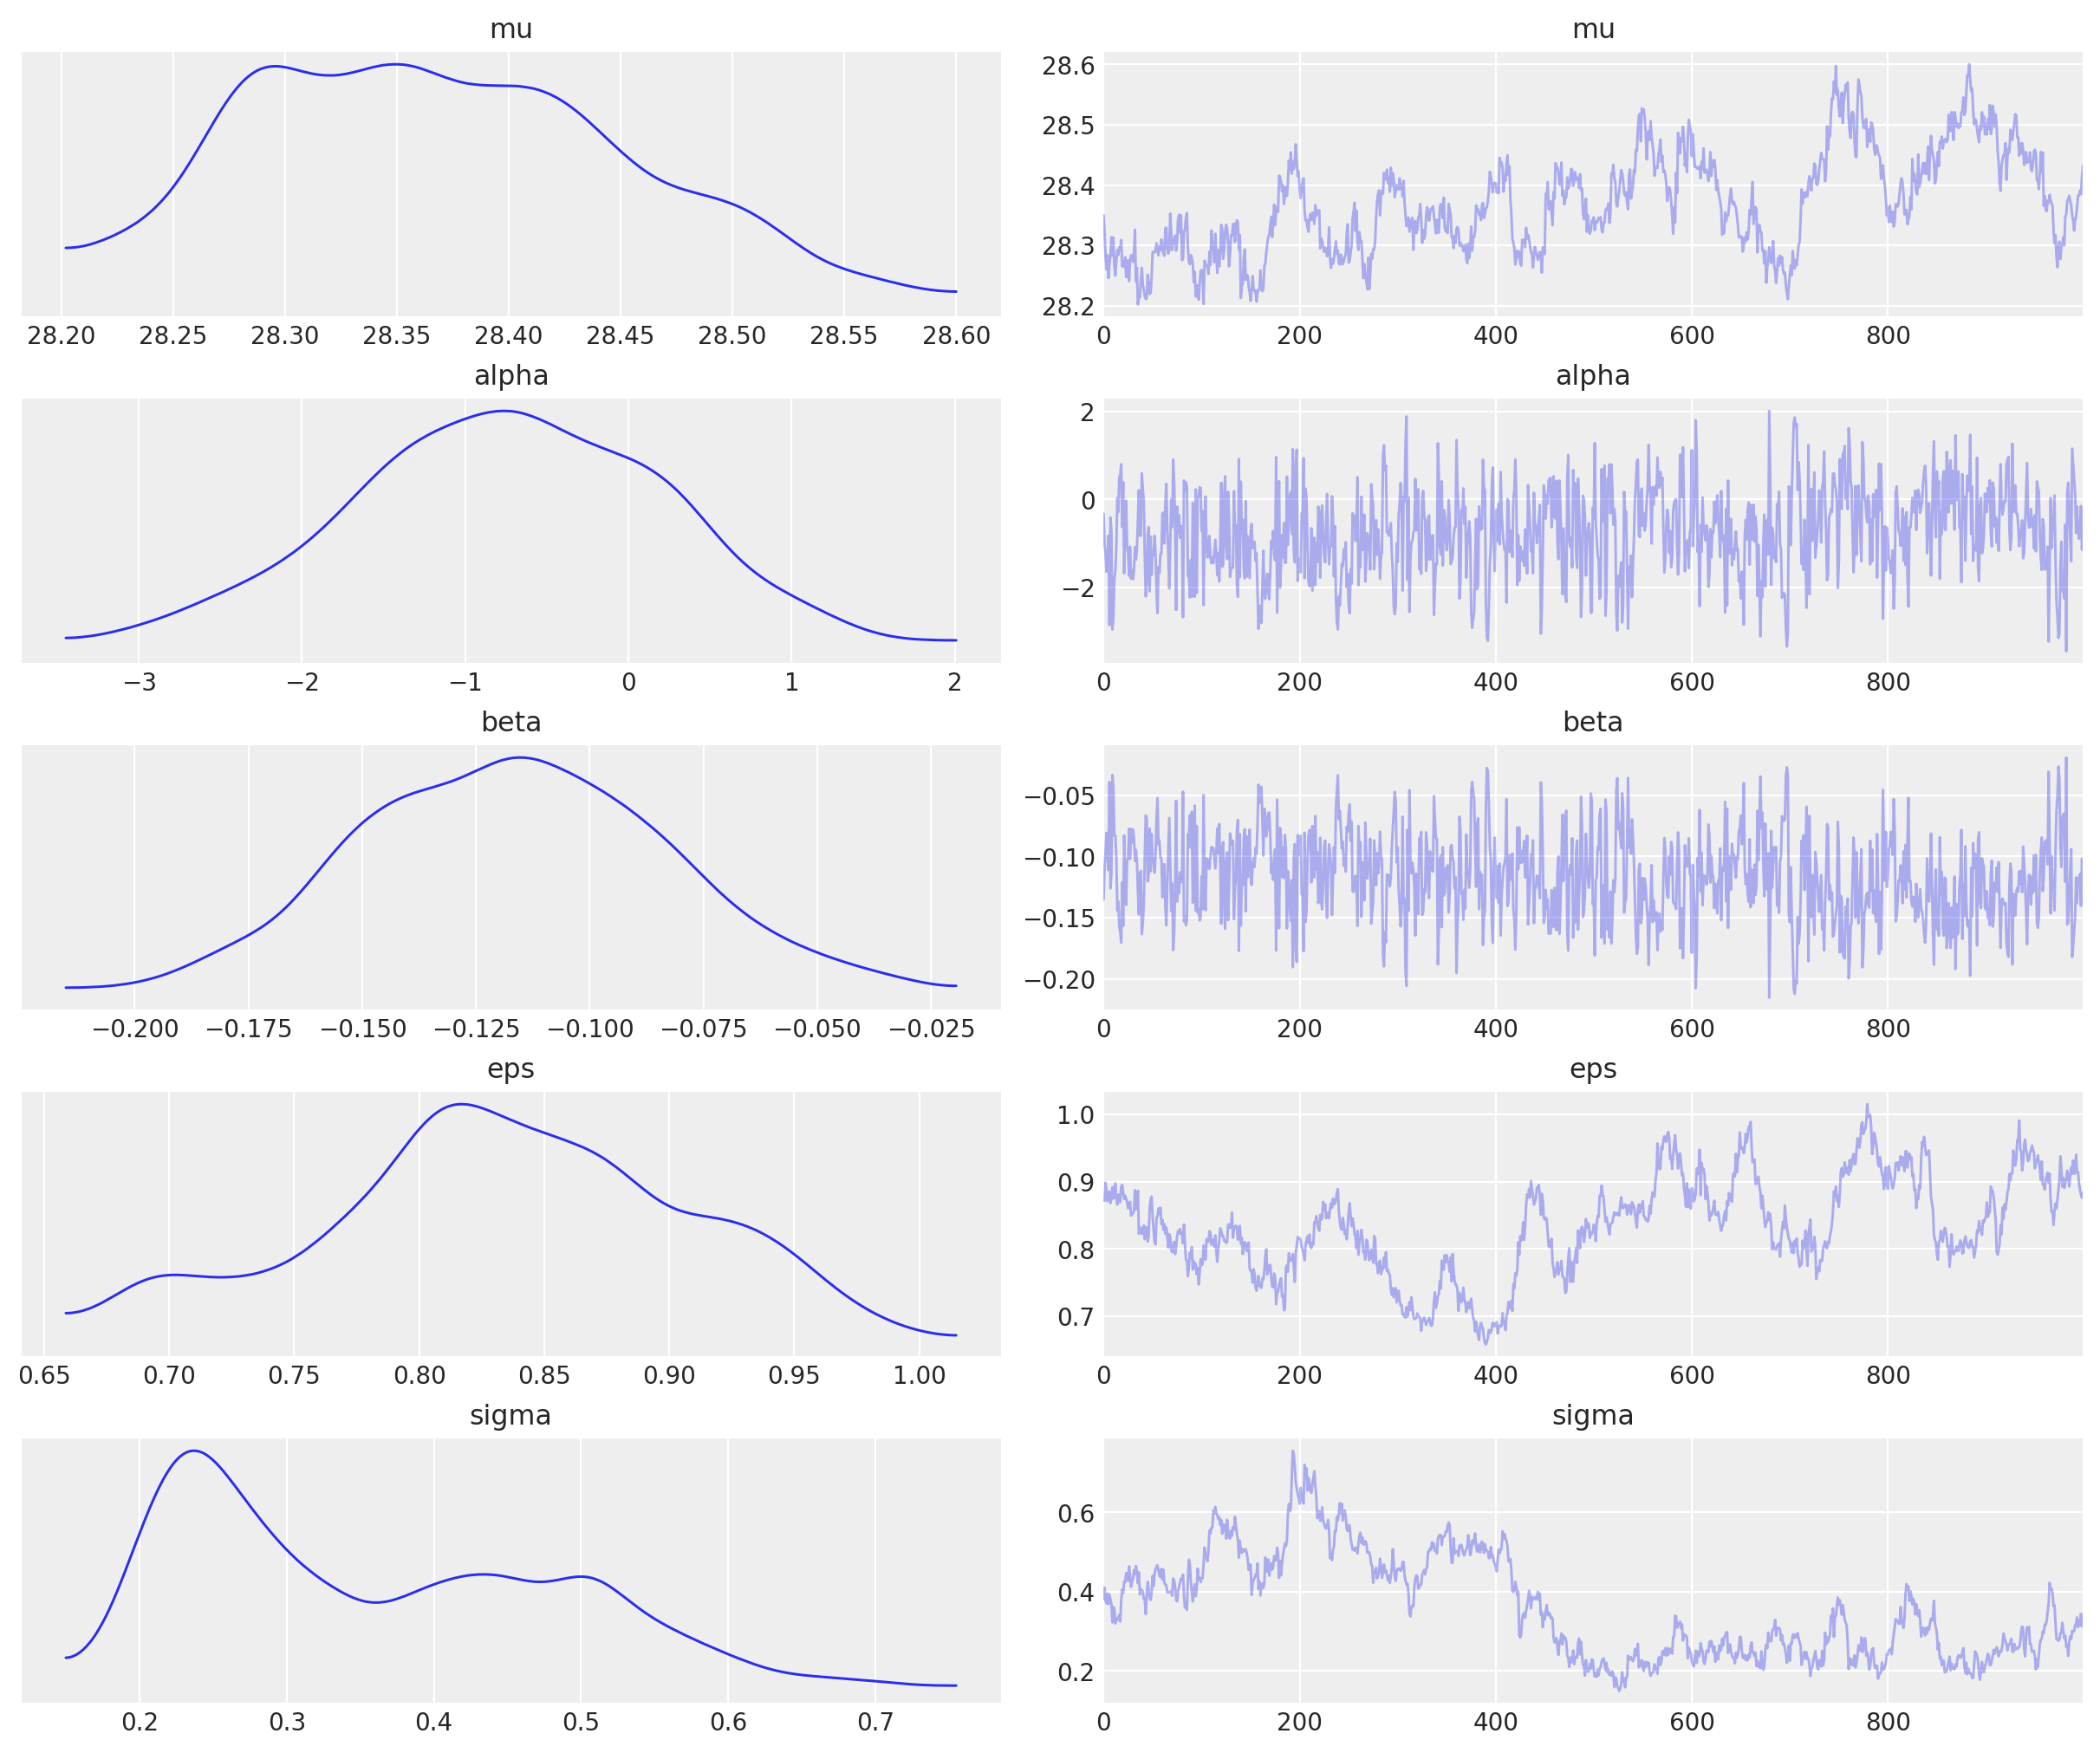

In [35]:
az.plot_trace(trace.posterior[['mu', 'alpha', 'beta', 'eps', 'sigma']])

# Adding model noise

In [21]:
with pm.Model() as model:

    # Priors
    sigma = pm.Exponential('sigma', 1)
    eps = pm.Exponential('eps', 1)
    mu = pm.Normal('mu', mu=np.nanmean(temp), sigma=1)
    phi = pm.ICAR('phi', W=adj.todense(), sigma=sigma)

    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1)

    # Likelihood
    T_est = pm.Normal('temp_est', mu + phi, sigma=eps, shape=N)
    T = pm.Normal('temp', mu=T_est, sigma=0.2, observed=temp_flat)

    # Note that we observe the counts, not the intensity
    intensity = pm.math.exp(alpha + beta*T_est)
    lam = pm.Poisson('lam', mu = intensity, observed=counts.flatten())
    
    # Sample
    trace = pm.sample(1000, tune=1000, chains=1)

/Users/zdc6/mambaforge/envs/pspws/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in temp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, eps, mu, phi, alpha, beta, temp_est, temp_unobserved]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 566 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


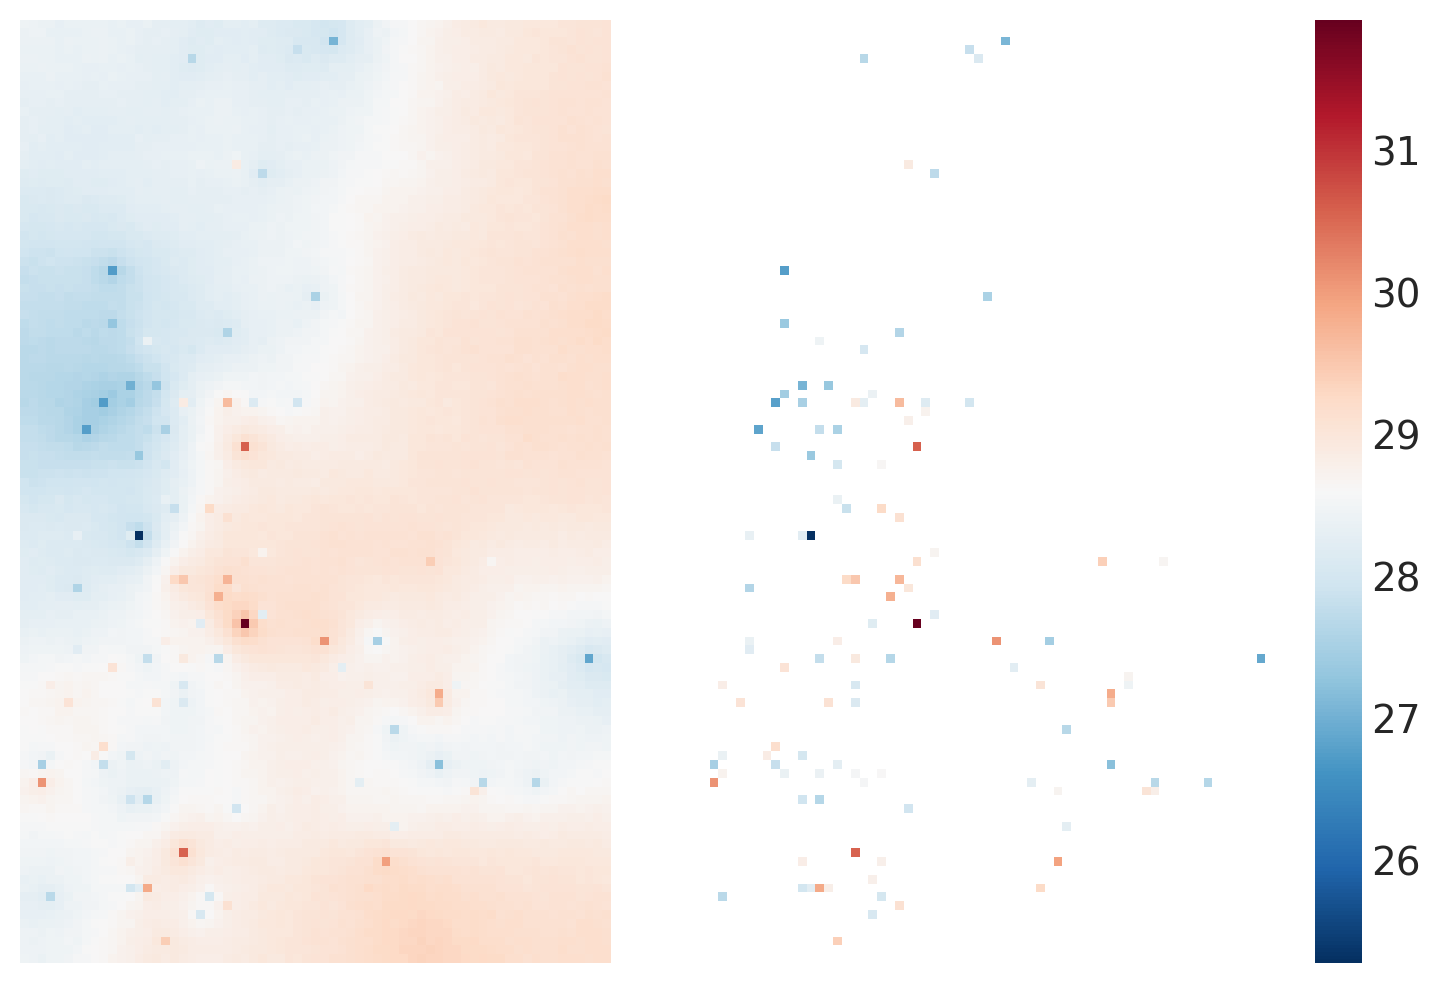

In [24]:
mean_temp = trace.posterior['temp_est'].mean(axis=(0,1)).values

plt.subplot(1,2,1)
plt.imshow(mean_temp.reshape(temp.shape), cmap='RdBu_r')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(temp, cmap='RdBu_r')
plt.axis('off')
plt.colorbar()

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'eps'}>, <Axes: title={'center': 'eps'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

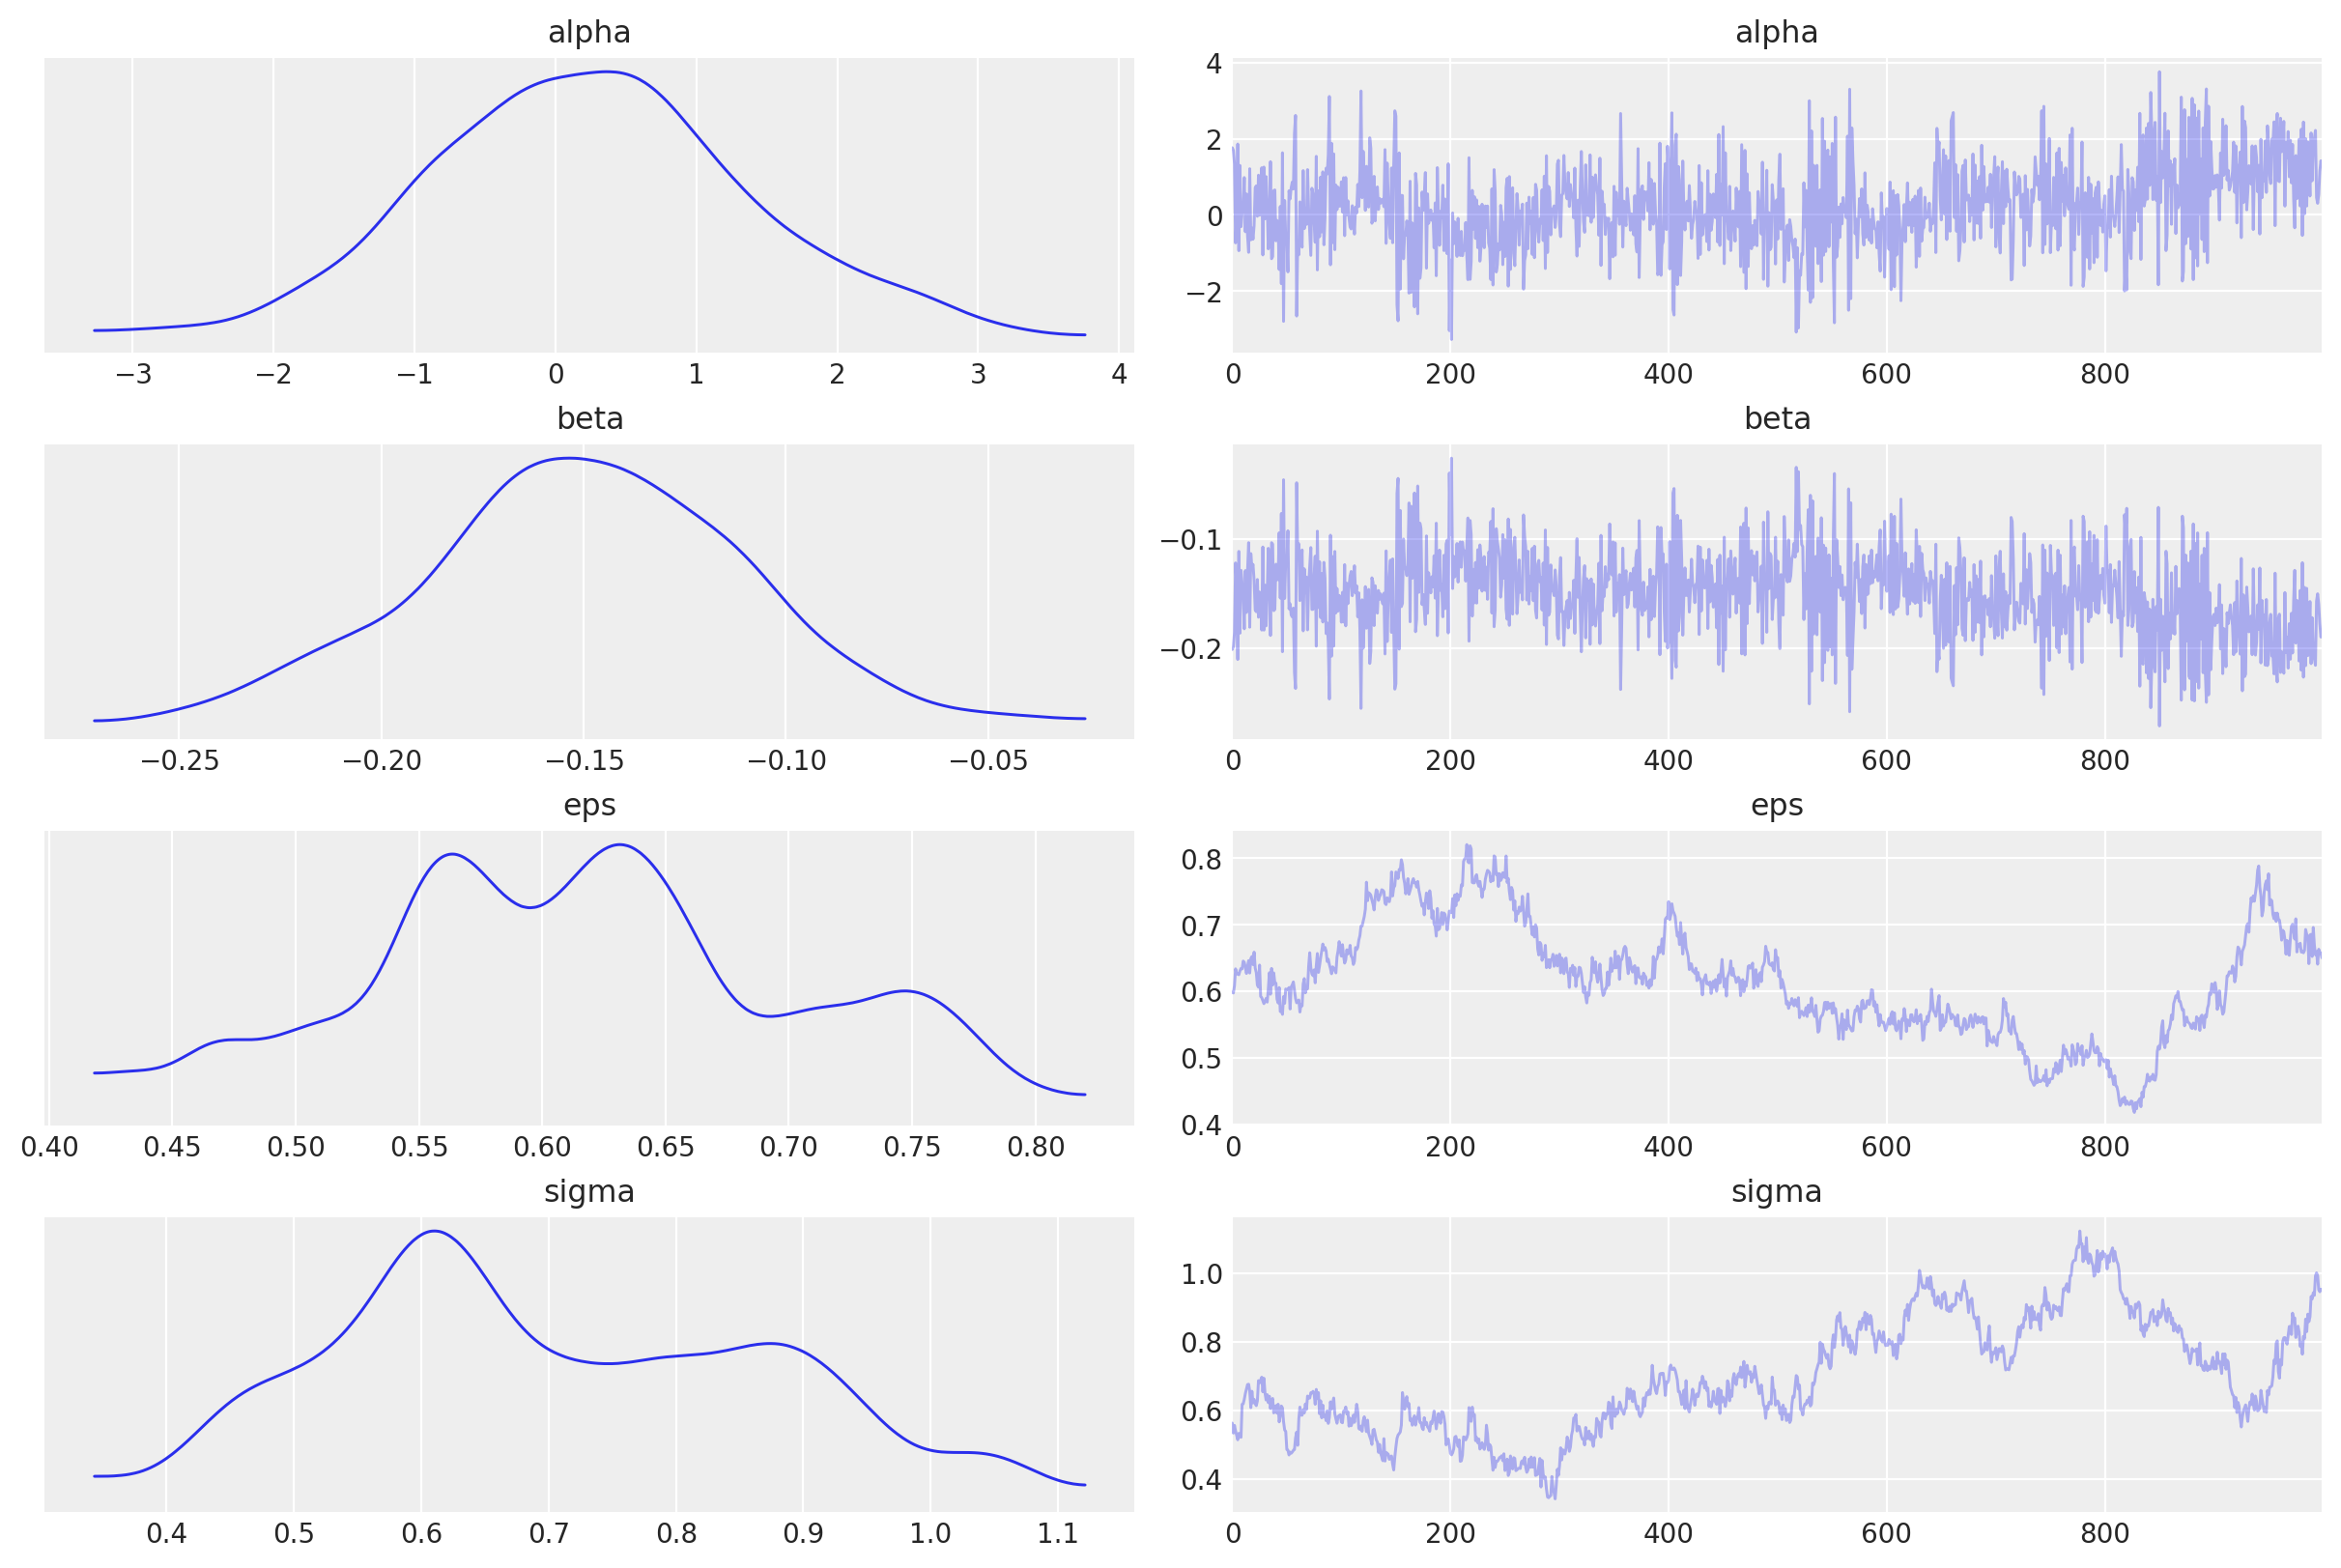

In [26]:
az.plot_trace(trace.posterior[['alpha', 'beta', 'eps', 'sigma']])